# Unaccompanied Migrant Children Machine Learning Model

## Import and load packages

In [25]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data modeling
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.model_selection import *
from sklearn.metrics import *

# Save models after fitting
import pickle

In [26]:
# Load dataset
df = pd.read_csv("data.csv")

# Display first few rows of dataframe
df.head()

/tmp/ipython-input-26-1414803612.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv")


,ID,Child's Country of Origin,Child's Gender,Child's Date of Entry,Child's Date of Release,Sponsor Zipcode,Sponsor Category,Relationship of Sponsor
0,1,Honduras,F,1/1/15,1/28/15,37863,1.0,Mother
1,2,Honduras,F,1/1/15,1/23/15,28212,1.0,Mother
2,3,Honduras,F,1/1/15,1/23/15,28212,2.0,Aunt
3,4,Honduras,M,1/2/15,1/30/15,27501,2.0,Brother
4,5,Honduras,M,1/1/15,2/13/15,78747,3.0,Other Cousin


In [29]:
# Make the sponsor zipcode type string
df['Sponsor Zipcode'] = df['Sponsor Zipcode'].astype(str)

# Display first few rows of dataframe
df.head()

,ID,Child's Country of Origin,Child's Gender,Child's Date of Entry,Child's Date of Release,Sponsor Zipcode,Sponsor Category,Relationship of Sponsor
0,1,Honduras,F,2015-01-01,2015-01-28,37863,1.0,Mother
1,2,Honduras,F,2015-01-01,2015-01-23,28212,1.0,Mother
2,3,Honduras,F,2015-01-01,2015-01-23,28212,2.0,Aunt
3,4,Honduras,M,2015-01-02,2015-01-30,27501,2.0,Brother
4,5,Honduras,M,2015-01-01,2015-02-13,78747,3.0,Other Cousin


## Exploratory data analysis and cleaning

In [30]:
# Gather basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553322 entries, 0 to 553321
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID                         553322 non-null  object        
 1   Child's Country of Origin  553322 non-null  object        
 2   Child's Gender             553322 non-null  object        
 3   Child's Date of Entry      553322 non-null  datetime64[ns]
 4   Child's Date of Release    553322 non-null  datetime64[ns]
 5   Sponsor Zipcode            553322 non-null  object        
 6   Sponsor Category           553322 non-null  object        
 7   Relationship of Sponsor    553322 non-null  object        
dtypes: datetime64[ns](2), object(6)
memory usage: 33.8+ MB


The ID and Sponsor Category shouldn't be treated as numbers. Change to string type:

In [31]:
# Change the ID and Sponsor Category categories to string type
df['ID'] = df['ID'].astype(str)
df['Sponsor Category'] = df['Sponsor Category'].astype(str)

# Change the child dates of entry and release to datetime type
df['Child\'s Date of Entry'] = pd.to_datetime(df['Child\'s Date of Entry'])
df['Child\'s Date of Release'] = pd.to_datetime(df['Child\'s Date of Release'])

# Confirm that it worked
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553322 entries, 0 to 553321
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID                         553322 non-null  object        
 1   Child's Country of Origin  553322 non-null  object        
 2   Child's Gender             553322 non-null  object        
 3   Child's Date of Entry      553322 non-null  datetime64[ns]
 4   Child's Date of Release    553322 non-null  datetime64[ns]
 5   Sponsor Zipcode            553322 non-null  object        
 6   Sponsor Category           553322 non-null  object        
 7   Relationship of Sponsor    553322 non-null  object        
dtypes: datetime64[ns](2), object(6)
memory usage: 33.8+ MB


In [32]:
# Convert column names to snake_case and shorter names
df = df.rename(columns = {
    'ID': 'id',
    'Child\'s Country of Origin': 'country',
    'Child\'s Gender': 'gender',
    'Child\'s Date of Entry': 'entry_date',
    'Child\'s Date of Release': 'release_date',
    'Sponsor Zipcode': 'sponsor_zipcode',
    'Sponsor Category': 'sponsor_code',
    'Relationship of Sponsor': 'relationship_of_sponsor'
})

# Display all column names
df.columns

Index(['id', 'country', 'gender', 'entry_date', 'release_date',
       'sponsor_zipcode', 'sponsor_code', 'relationship_of_sponsor'],
      dtype='object')

In [33]:
# Create a days detained column by subtracting the entry date from the release date
df['days_detained'] = (df['release_date'] - df['entry_date']).dt.days

# Make this column by assigning 0 if a child spent less than 30 days detained, and 1 otherwise
df['detained_for_month'] = np.where(df['days_detained'] >= 30, 1, 0)

# Display first few rows of dataframe
df.head()

,id,country,gender,entry_date,release_date,sponsor_zipcode,sponsor_code,relationship_of_sponsor,days_detained,detained_for_month
0,1,Honduras,F,2015-01-01,2015-01-28,37863,1.0,Mother,27,0
1,2,Honduras,F,2015-01-01,2015-01-23,28212,1.0,Mother,22,0
2,3,Honduras,F,2015-01-01,2015-01-23,28212,2.0,Aunt,22,0
3,4,Honduras,M,2015-01-02,2015-01-30,27501,2.0,Brother,28,0
4,5,Honduras,M,2015-01-01,2015-02-13,78747,3.0,Other Cousin,43,1


Make column to identify place by continent rather than country, for convenience

In [34]:
# Import continent library
from pycountry_convert import country_name_to_country_alpha2, country_alpha2_to_continent_code, convert_continent_code_to_continent_name

# Function to get the continent from the country using the libraries above
def get_continent(row):
    try:
        country_code = country_name_to_country_alpha2(row)
        continent_code = country_alpha2_to_continent_code(country_code)
        continent_name = convert_continent_code_to_continent_name(continent_code)

        return continent_name
    except:
        return 'N/A'

df['continent'] = df['country'].apply(get_continent)

# See how it looks
df.head()

,id,country,gender,entry_date,release_date,sponsor_zipcode,sponsor_code,relationship_of_sponsor,days_detained,detained_for_month,continent
0,1,Honduras,F,2015-01-01,2015-01-28,37863,1.0,Mother,27,0,North America
1,2,Honduras,F,2015-01-01,2015-01-23,28212,1.0,Mother,22,0,North America
2,3,Honduras,F,2015-01-01,2015-01-23,28212,2.0,Aunt,22,0,North America
3,4,Honduras,M,2015-01-02,2015-01-30,27501,2.0,Brother,28,0,North America
4,5,Honduras,M,2015-01-01,2015-02-13,78747,3.0,Other Cousin,43,1,North America


In [35]:
# Delete columns that are no longer needed for data visualization and model fitting
del df['country']
del df['sponsor_zipcode']
del df['relationship_of_sponsor']
del df['days_detained']

# View cleaned dataset
df.head()

,id,gender,entry_date,release_date,sponsor_code,detained_for_month,continent
0,1,F,2015-01-01,2015-01-28,1.0,0,North America
1,2,F,2015-01-01,2015-01-23,1.0,0,North America
2,3,F,2015-01-01,2015-01-23,2.0,0,North America
3,4,M,2015-01-02,2015-01-30,2.0,0,North America
4,5,M,2015-01-01,2015-02-13,3.0,1,North America


In [36]:
# View the complete basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553322 entries, 0 to 553321
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  553322 non-null  object        
 1   gender              553322 non-null  object        
 2   entry_date          553322 non-null  datetime64[ns]
 3   release_date        553322 non-null  datetime64[ns]
 4   sponsor_code        553322 non-null  object        
 5   detained_for_month  553322 non-null  int64         
 6   continent           553322 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 29.6+ MB


In [37]:
# Gather descriptive statistics about the data
df.describe()

,entry_date,release_date,detained_for_month
count,553322,553322,553322.000000
mean,2020-03-03 13:13:57.095217408,2020-04-09 06:24:43.169655040,0.409169
min,2015-01-01 00:00:00,2015-01-09 00:00:00,0.000000
25%,2018-03-28 00:00:00,2018-05-22 00:00:00,0.000000
50%,2021-04-07 00:00:00,2021-05-16 00:00:00,0.000000
75%,2022-03-16 00:00:00,2022-04-11 00:00:00,1.000000
max,2023-05-23 00:00:00,2023-05-26 00:00:00,1.000000
std,NaN,NaN,0.491681


### Check for missing values

In [38]:
# Check missing values
df.isna().sum()

,0
id,0
gender,0
entry_date,0
release_date,0
sponsor_code,0
detained_for_month,0
continent,0


**No missing values, move on.**

### Check duplicates

In [39]:
# Check for duplicates
df.duplicated().sum()

np.int64(0)

**No duplicates, moving on.**

**No duplicates, move on.**

## Data visualizations

In [41]:
# Drop 'nan' in sponsor_code
df = df[df['sponsor_code'] != 'nan']

# Check that it worked
df['sponsor_code'].value_counts()

,count
sponsor_code,
2.0,258165
1.0,230817
3.0,63684


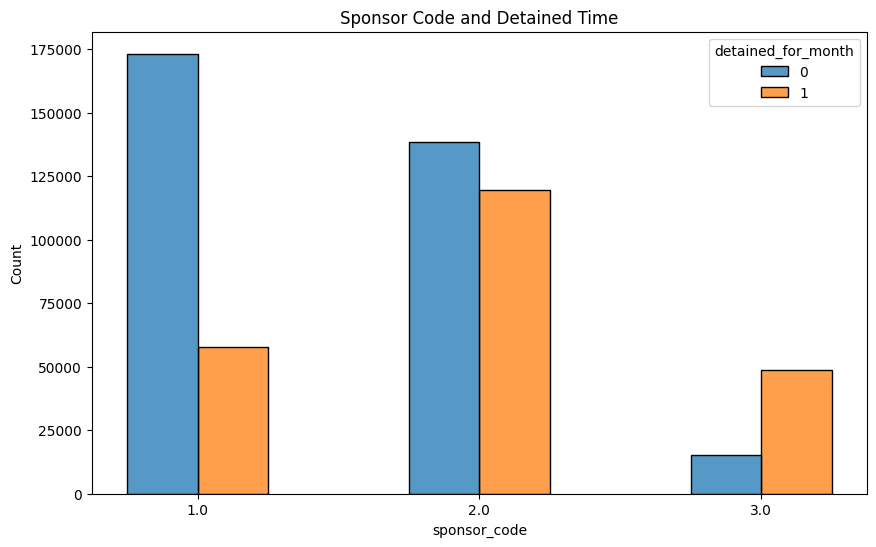

In [42]:
# Histogram of sponsor code and detainment time
plt.figure(figsize = (10, 6))
sponsor_long = df[df['detained_for_month'] == 0]['sponsor_code']
sponsor_quick = df[df['detained_for_month'] == 1]['sponsor_code']
sns.histplot(data = df, x = 'sponsor_code', hue = 'detained_for_month', multiple = 'dodge', shrink = 0.5)
plt.title('Sponsor Code and Detained Time')
plt.show()

In [43]:
# Drop 'N/A' in continent
df = df[df['continent'] != 'N/A']

# Check that it worked
df['continent'].value_counts()

,count
continent,
North America,530247
South America,15134
Asia,6102
Europe,703
Africa,448


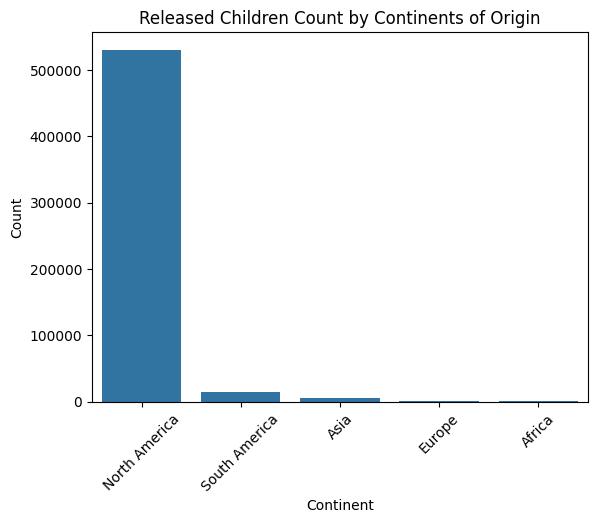

In [44]:
# Bar graph of each continent of origin
sns.barplot(x = df['continent'].value_counts().index, y = df['continent'].value_counts().values)
plt.title('Released Children Count by Continents of Origin')
plt.xlabel('Continent')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

In [45]:
# Get percentage of children from North America
df['continent'].value_counts(normalize = True)['North America']

np.float64(0.9594903679469595)

**96% of released detained children came from North America, the same as the U.S.**

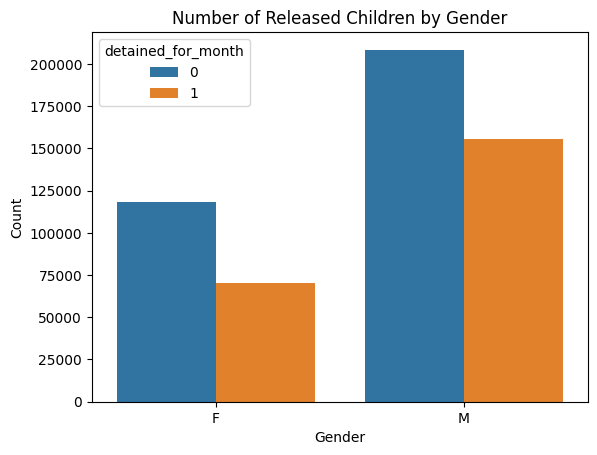

In [62]:
# Make a bar plot counting the number of children per gender, with detained_for_month as the hue
sns.countplot(x = 'gender', hue = 'detained_for_month', data = df)
plt.title('Number of Released Children by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Gender does not seem to make a difference when it comes to how long a child stays detained for. The height differences just indicate how many children identify with that gender.

Males are more often released by distant relatives, by 72%. Meanwhile, females are often released by close relatives with a 41% rate.

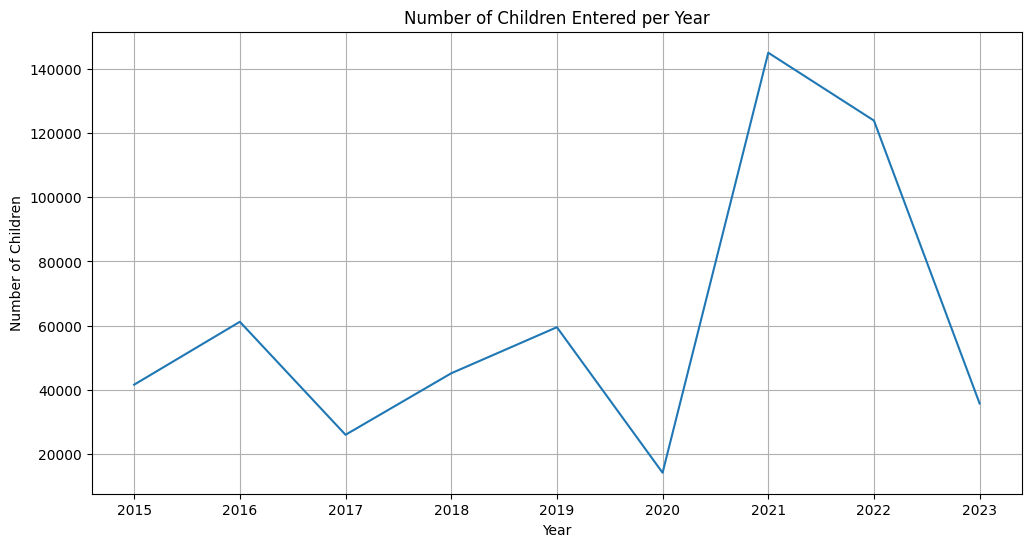

In [54]:
# Make a column counting the children per year
children_per_year = df.groupby(df['entry_date'].dt.year)['id'].count()

# Line plot of children entering the U.S. per year
plt.figure(figsize=(12, 6))
sns.lineplot(x=children_per_year.index, y=children_per_year.values)
plt.title('Number of Children Entered per Year')
plt.xlabel('Year')
plt.ylabel('Number of Children')
plt.grid(True)
plt.show()

**Insights**
- Children are likely to stay detained longer if a distant relative must sponsor their release.
- 96% of unaccompanied migrant children come from North America, the same continent as the U.S.
- Gender does not determine how long a child stays in custody.
- A spike in unaccompanied children enters the U.S. is observed during the pandemic and Joe Biden's presidency beginning in 2021.

## Model Building and Results

In [67]:
# Copy columns to be encoded
df_enc = df[['gender', 'sponsor_code', 'detained_for_month', 'continent']].copy()

# Encode gender by mapping
df_enc['gender'] = df_enc['gender'].map({'M': 0, 'F': 1})

# Encode sponsor_code by category
df_enc['sponsor_code'] = df_enc['sponsor_code'].astype('category').cat.codes

# Encode continent by dummy
df_enc = pd.get_dummies(df_enc, columns = ['continent'])

# Display first few rows of dataframe
df_enc.head()

,gender,sponsor_code,detained_for_month,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_South America
0,1,0,0,False,False,False,True,False
1,1,0,0,False,False,False,True,False
2,1,1,0,False,False,False,True,False
3,0,1,0,False,False,False,True,False
4,0,2,1,False,False,False,True,False


In [68]:
# Isolate the outcome variable
y = df_enc['detained_for_month']

# Display the first few rows of y
y.head()

,detained_for_month
0,0
1,0
2,0
3,0
4,1


In [69]:
# Select the features
X = df_enc.drop(columns = ['detained_for_month'])

# Display the first few rows of X
X.head()

,gender,sponsor_code,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_South America
0,1,0,False,False,False,True,False
1,1,0,False,False,False,True,False
2,1,1,False,False,False,True,False
3,0,1,False,False,False,True,False
4,0,2,False,False,False,True,False


In [70]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 0)

In [71]:
# Instantiate model
tree = DecisionTreeClassifier(random_state = 0)

# Dictionary of hyperparameters to search over
cv_params = {
    'max_depth': [4, 6, 8, None],
    'min_samples_leaf': [2, 5, 1],
    'min_samples_split': [2, 4, 6]
  }

# Dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring = scoring, cv = 4, refit = 'roc_auc')

In [72]:
# Fit the tree
%%time
tree1.fit(X_train, y_train)

CPU times: user 46.1 s, sys: 111 ms, total: 46.2 s
Wall time: 46.4 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [73]:
# Find the best parameters
tree1.best_params_

{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [74]:
# Find the best AUC score on the CV
tree1.best_score_

np.float64(0.6797689874298275)

In [80]:
# DISCLAIMER: THIS FUNCTION IS INSPIRED BY THE GOOGLE ADVANCED DATA ANALYTICS CERTIFICATE.

# Pre-defined function to get the metrics from the model
def results(model_name:str, model_object, metric:str):

  # Dictionary of mean metrics
  metric_dict = {
      'accuracy': 'mean_test_accuracy',
      'precision': 'mean_test_precision',
      'recall': 'mean_test_recall',
      'f1': 'mean_test_f1',
      'auc': 'mean_test_roc_auc'
  }

  # Get the row with the best results
  cv_results = pd.DataFrame(model_object.cv_results_)
  best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

  # Extract the metrics from the best row
  accuracy = best_estimator_results['mean_test_accuracy']
  precision = best_estimator_results['mean_test_precision']
  recall = best_estimator_results['mean_test_recall']
  f1 = best_estimator_results['mean_test_f1']
  auc = best_estimator_results['mean_test_roc_auc']

  # Put the best results in a table
  results = pd.DataFrame({
      'Model': [model_name],
      'Accuracy': [accuracy],
      'Precision': [precision],
      'Recall': [recall],
      'F1': [f1],
      'AUC': [auc]
  })
  return results

In [81]:
results('Decision Tree', tree1, 'auc')

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree,0.652165,0.763691,0.21572,0.336406,0.679769


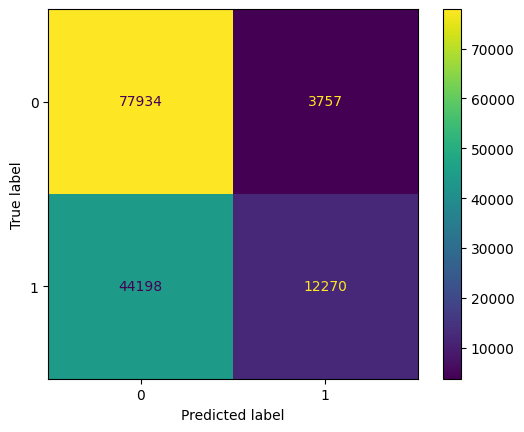

In [83]:
# Confusion matrix
y_pred = tree1.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = tree1.classes_)
display.plot()
plt.show()

_Positive: Detained for 1 month, negative = less than a month_
- **True negative**: 77934
- False negative: 44198
- False positive: 3757
- **True positive**: 12270

**~65% of predictions are accurate.**

In [86]:
# Gini importance
tree1_importances = pd.DataFrame(tree1.best_estimator_.feature_importances_,
                                 columns = ['gini_importance'],
                                 index = X.columns)

tree1_importances.sort_values(by = 'gini_importance', ascending = False)

# Features with importances > 0
tree1_importances = tree1_importances[tree1_importances['gini_importance'] > 0]
tree1_importances

,gini_importance
gender,0.009855
sponsor_code,0.968282
continent_Africa,0.001819
continent_Asia,0.000971
continent_Europe,0.000783
continent_North America,0.002087
continent_South America,0.016203


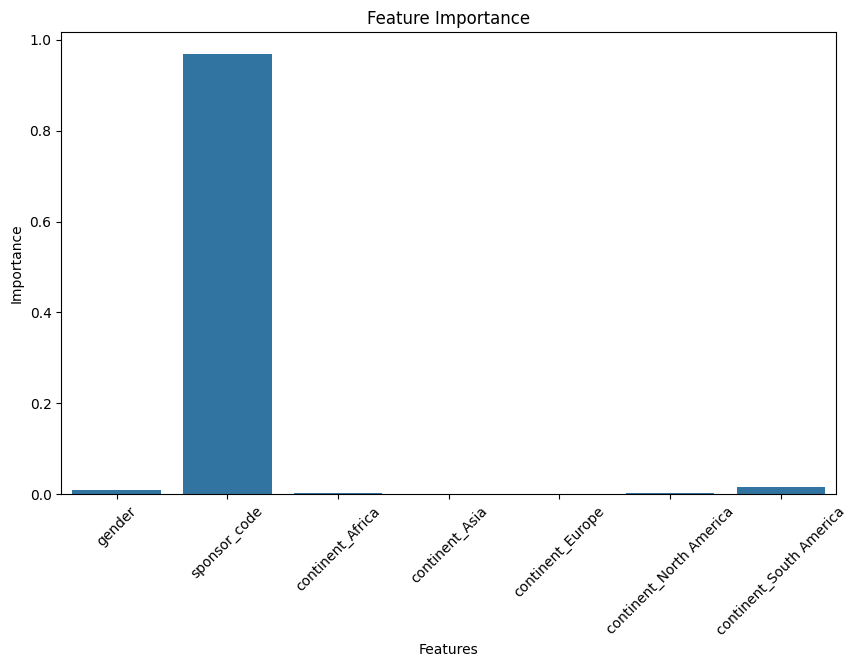

In [89]:
# Bar chart to visualize the most important features as determined above
plt.figure(figsize = (10, 6))
sns.barplot(x = tree1_importances.index, y = tree1_importances['gini_importance'])
plt.title('Feature Importance')
plt.xticks(rotation = 45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

## Results
According to the model, the most important feature is clearly the sponsor's code relationship with the child. Whether they are a parent, or some distant family member, **whoever is available to release them affects their time spent in detainment by 97%.**

For a more accurate test, we may consider trying different models for comparison that may increase the accuracy ratings. For example, we might try a logistic regression model and not rely on trees at all.

As for the model itself, **data leakage is still a concern.** The accuracy may dramatically increase, or the precision might dramatically decrease. This all depends on the processing power of the computer being used. In this case, more tests and model building may be necessary.